In [1]:
import matplotlib.pyplot as plt
import torch

from coolchic.enc.io.io import load_frame_data_from_tensor
from coolchic.hypernet.hypernet import DeltaWholeNet
from coolchic.utils.paths import CONFIG_DIR, COOLCHIC_REPO_ROOT, DATA_DIR
from coolchic.utils.tensors import load_img_from_path
from coolchic.utils.types import HypernetRunConfig, load_config

plt.rcParams["figure.dpi"] = 300

In [2]:
# load image from clic20
img_path = DATA_DIR / "clic20-pro-valid" / "gian-reto-tarnutzer-45212.png"
img = load_frame_data_from_tensor(load_img_from_path(img_path)).data
img = img[..., :512, :512]  # crop to 512x512

In [3]:
# Plot image in tensor
import matplotlib.pyplot as plt


def plot_img(img):
    img = img.squeeze()
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()

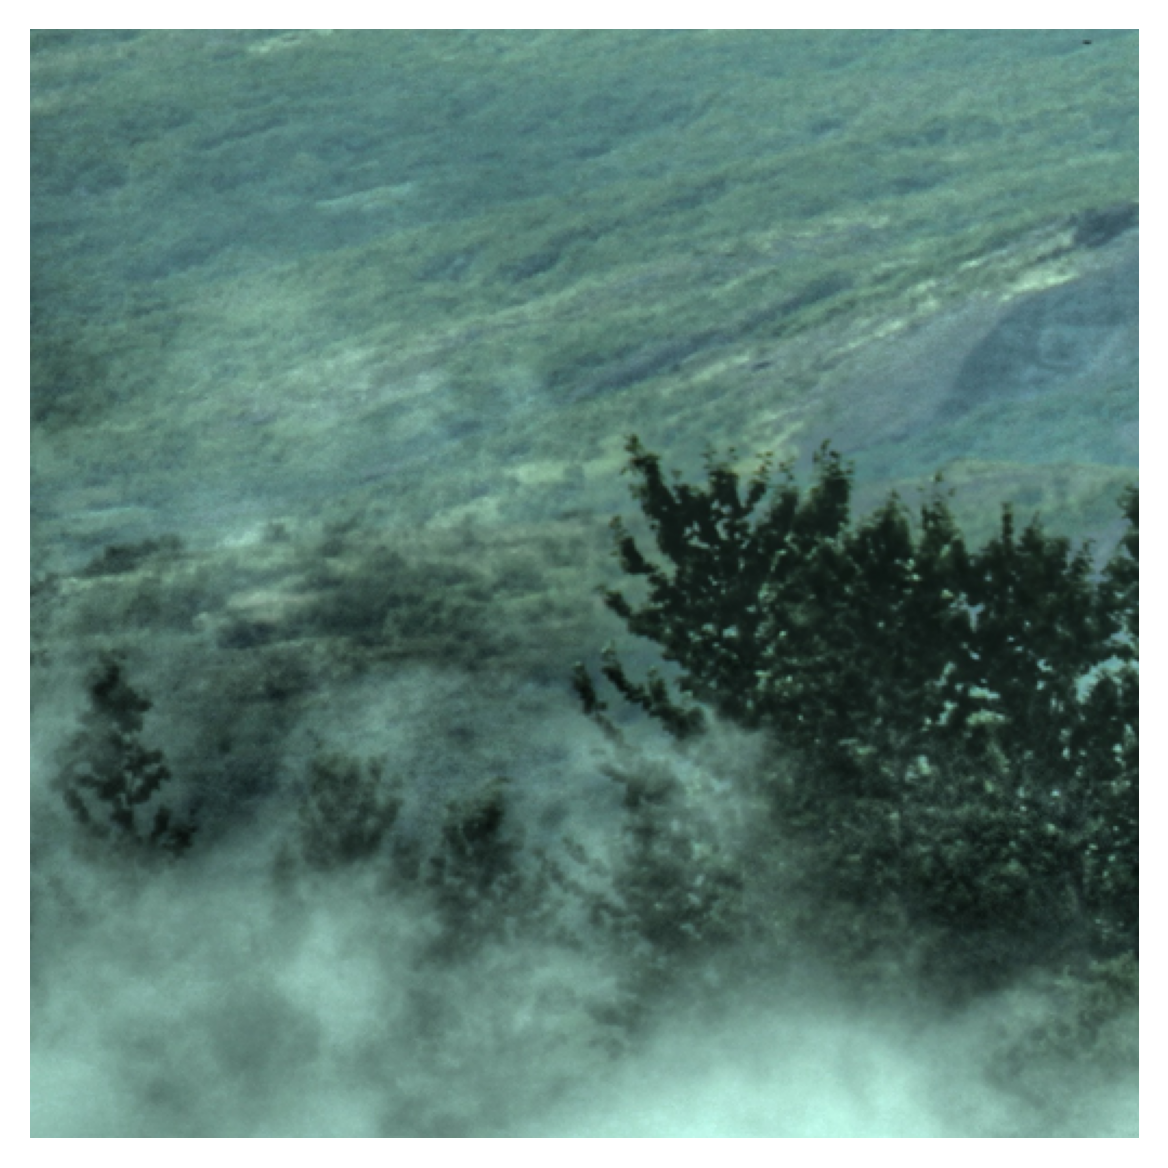

In [4]:
plot_img(img)  # plot the compressed image

In [5]:
# instantiate a deltawholenet
cfg_path = CONFIG_DIR / "exps" / "delta-hn" / "ups-best-orange" / "config_04.yaml"
cfg = load_config(cfg_path, HypernetRunConfig)
checkpoint_path = COOLCHIC_REPO_ROOT / "best_delta_config04.pt"

net = DeltaWholeNet(cfg.hypernet_cfg)
net.load_state_dict(torch.load(checkpoint_path, weights_only=True, map_location="cpu"))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /local/home/taczel/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


FileNotFoundError: [Errno 2] No such file or directory: '/local/home/taczel/projects/cool-chic-pep/best_delta_config04.pt'

In [6]:
with torch.no_grad():
    net.eval()  # set to eval mode
    compre_img = net.forward(
        # img.unsqueeze(0),  # add batch dimension
        img,
        quantizer_noise_type="none",
        quantizer_type="true_ste",
    )

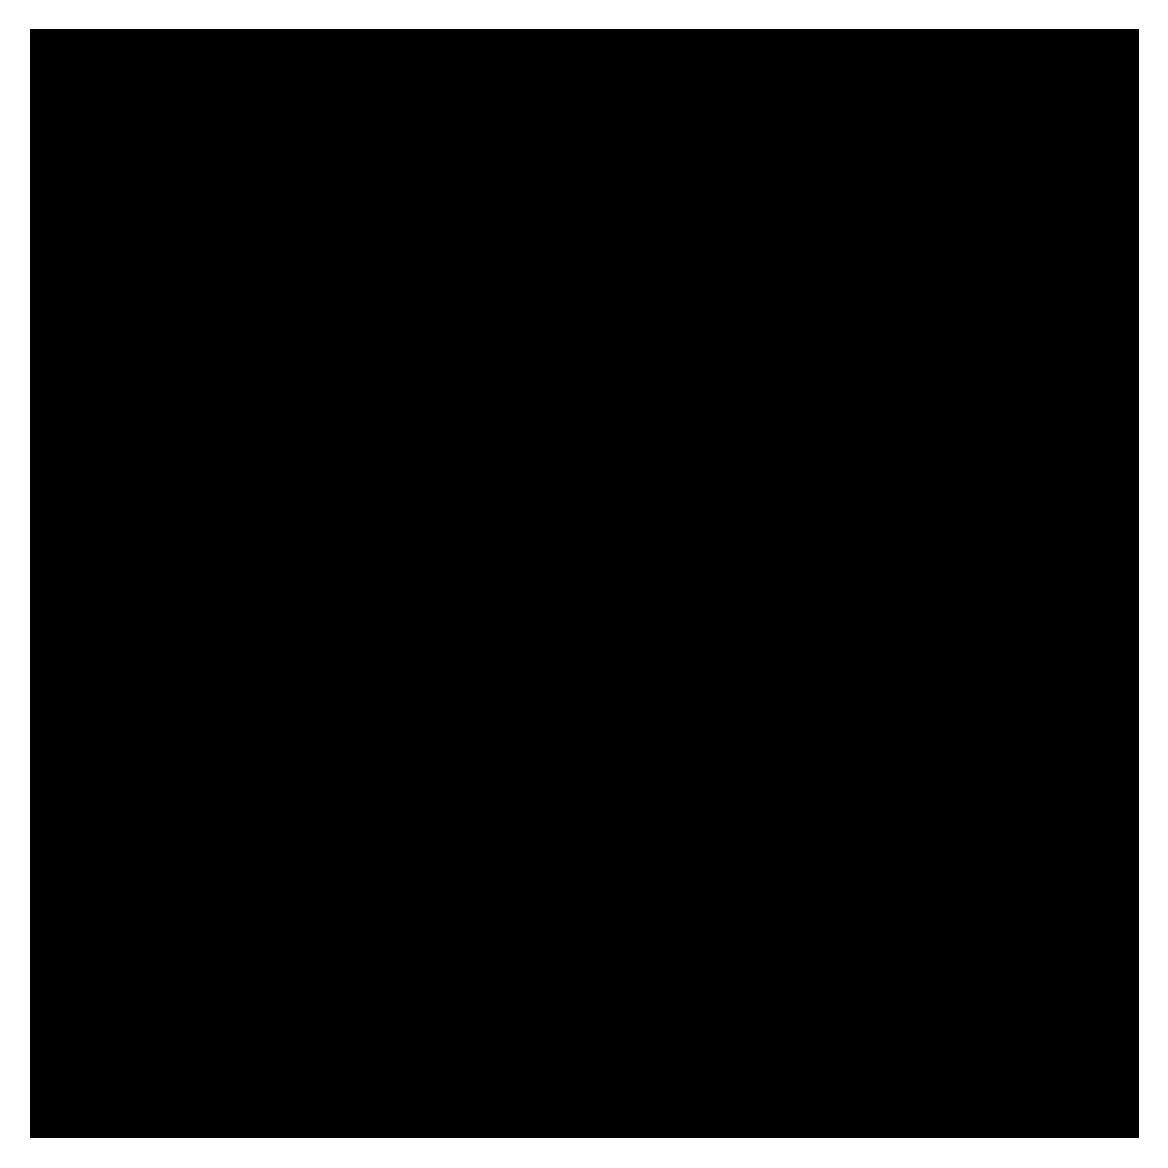

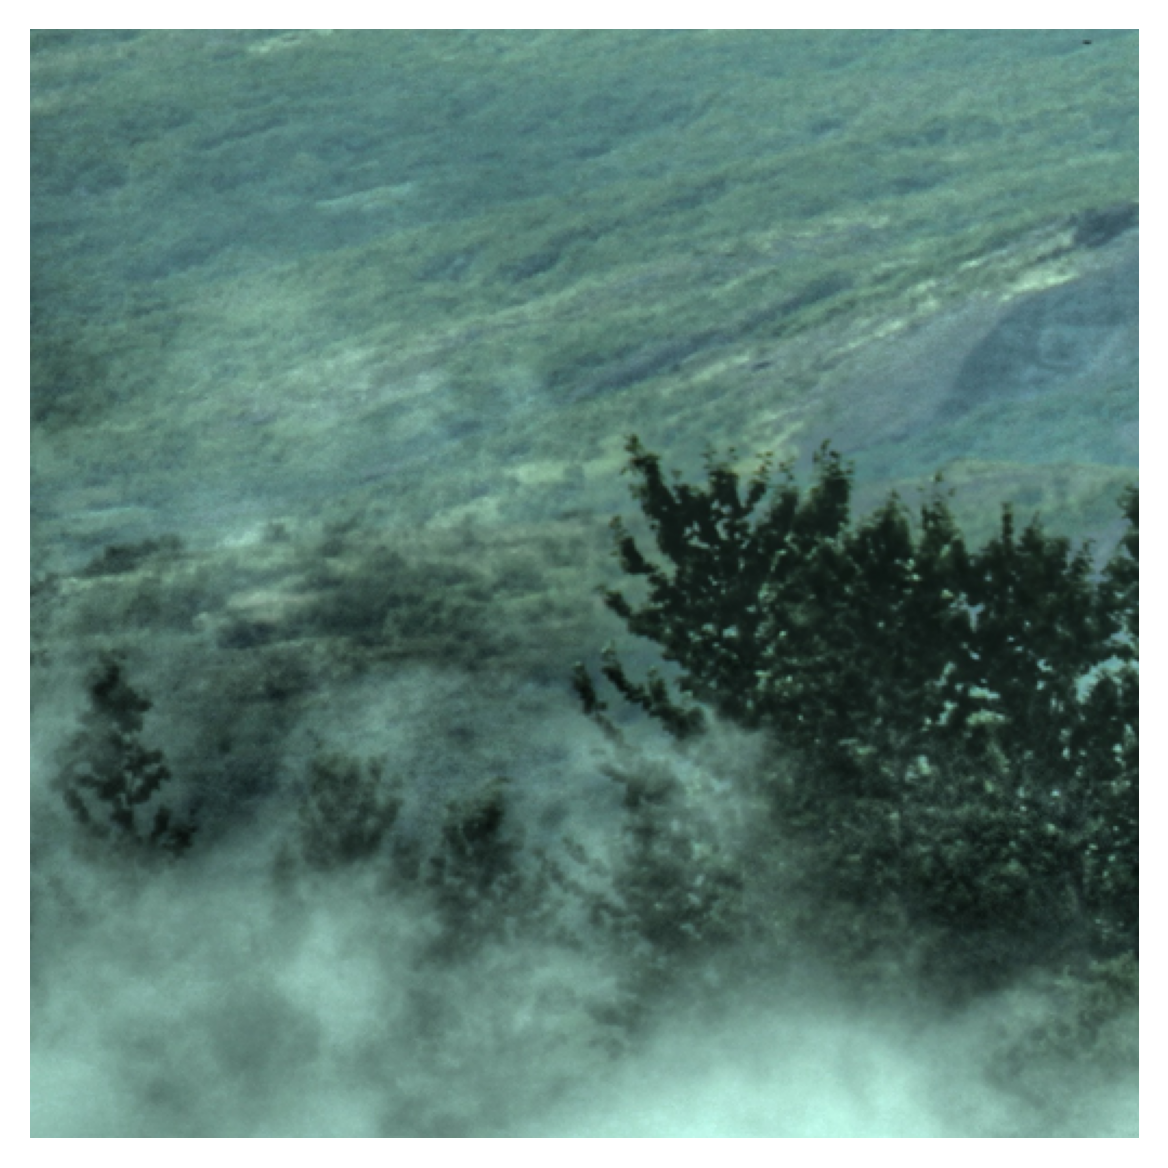

In [7]:
plot_img(compre_img[0].squeeze())
plot_img(img[0])

In [35]:
from coolchic.hypernet.common import add_deltas

net.eval()
with torch.no_grad():
    latents, synth_deltas, arm_deltas, ups_deltas = net.hypernet.forward(img)
    deltas = {"synthesis": synth_deltas, "arm": arm_deltas, "ups": ups_deltas}
    model_params = {
        "synthesis": dict(net.mean_decoder.synthesis.named_parameters()),
        "arm": dict(net.mean_decoder.arm.named_parameters()),
    }
    added_params = add_deltas(
        net.mean_decoder.named_parameters(),
        deltas["synthesis"],
        deltas["arm"],
        deltas["ups"],
        batch_size=1,
    )

effective_params = {
    "synthesis": {},
    "arm": {},
    "ups": {},
}
for key in added_params:
    if "synthesis" in key:
        effective_params["synthesis"][key] = added_params[key]
    elif "arm" in key:
        effective_params["arm"][key] = added_params[key]
    elif "ups" in key:
        effective_params["ups"][key] = added_params[key]

Laplace entropy (bits): 0.02144581
Laplace entropy (bits): 0.023213154
Saved synthesis_delta.csv and synthesis_effective.csv
Laplace entropy (bits): 0.037649225
Laplace entropy (bits): 0.024242828
Saved arm_delta.csv and arm_effective.csv
Laplace entropy (bits): 0.35151628
Laplace entropy (bits): 0.045820083
Saved ups_delta.csv and ups_effective.csv


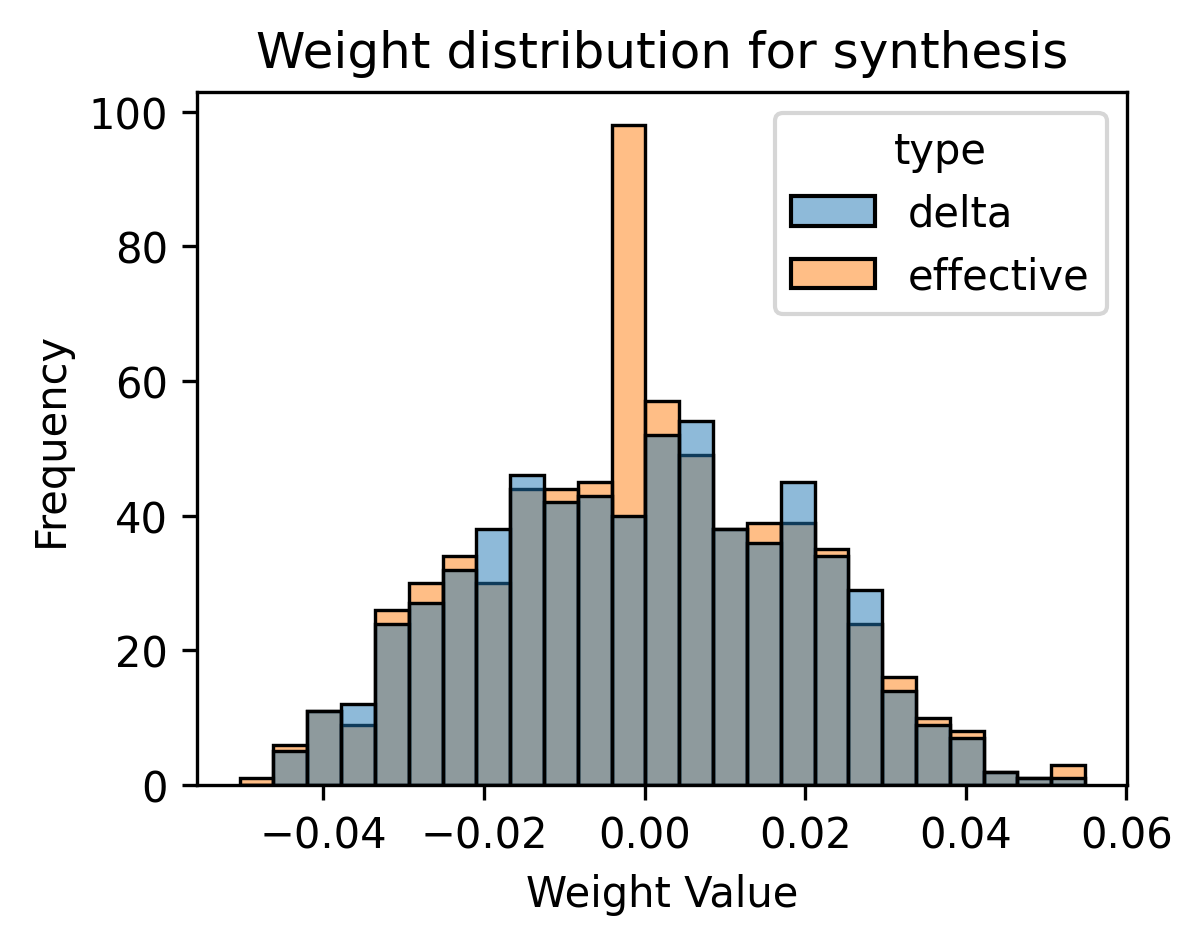

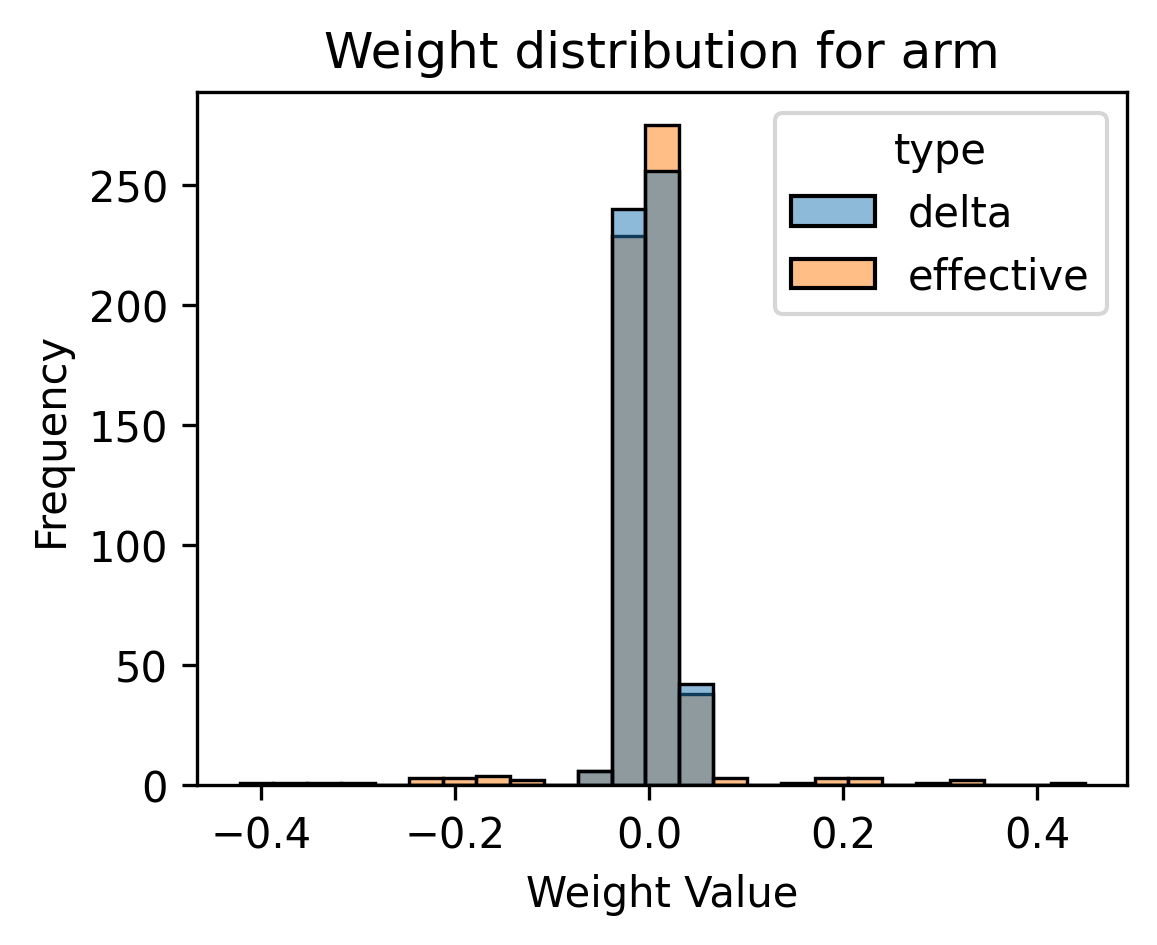

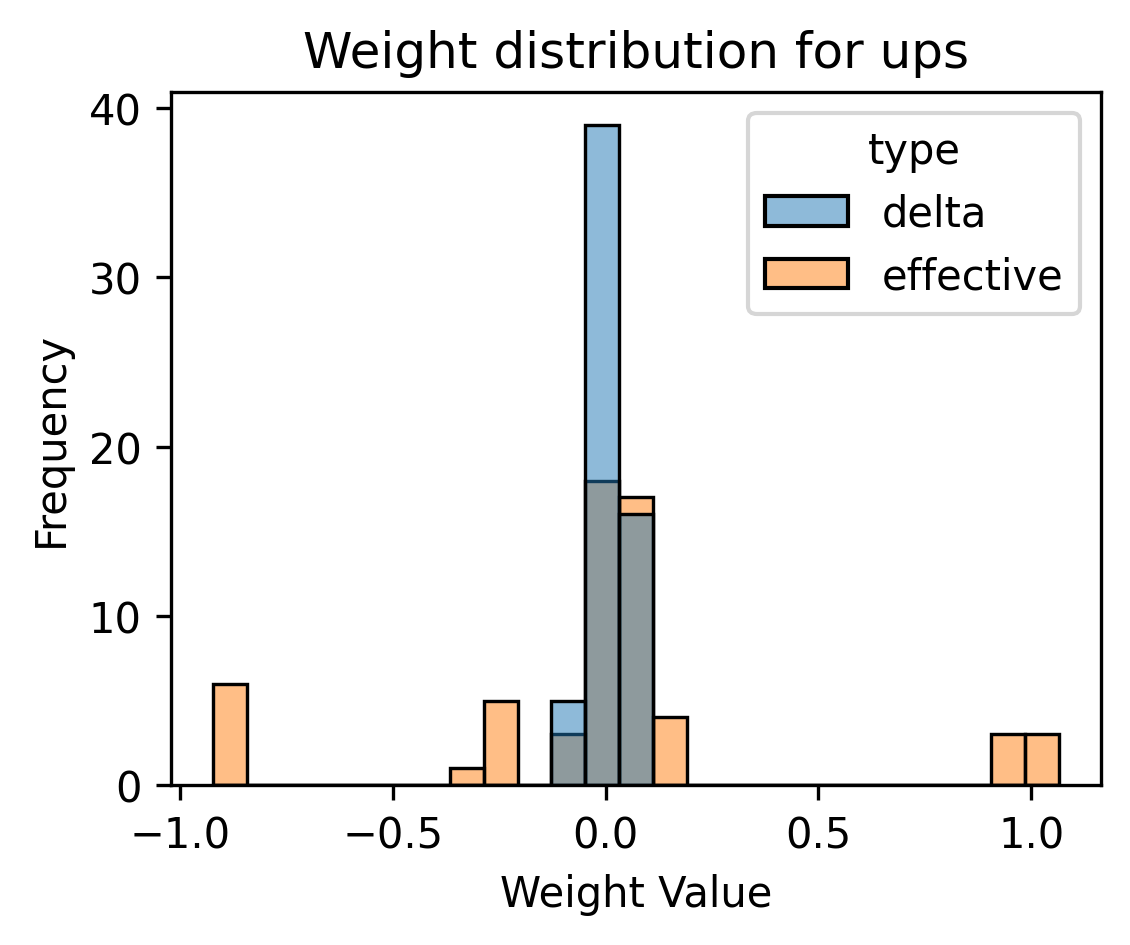

In [41]:
def hist_weights(module, deltas, effective):
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    flat_deltas = (
        torch.cat([v.view(-1) for k, v in deltas[module].items()])
        .cpu()
        .detach()
        .numpy()
    )
    flat_effective = (
        torch.cat([v.view(-1) for k, v in effective[module].items()])
        .cpu()
        .detach()
        .numpy()
    )
    data = pd.DataFrame(
        {
            "type": ["delta"] * len(flat_deltas) + ["effective"] * len(flat_effective),
            "value": list(flat_deltas) + list(flat_effective),
        }
    )
    import numpy as np
    from scipy.stats import laplace
    
    def laplace_entropy(values):
        loc, scale = laplace.fit(values)
        # print(f"Fitted scale b: {scale}")
        entropy_nats = np.log(2 * scale * np.e)
        entropy_bits = entropy_nats / np.log(2)
        # print(f"Entropy (bits): {entropy_bits}")
        return entropy_bits

    def laplace_std(values):
        
        loc, scale = laplace.fit(values)
        return (2*scale**2)**0.5



    # print(data[data['type']=='delta'])
    # print(entropy_discrete(data[data['type']=='delta']['value']))
    # print(entropy_discrete(data[data['type']=='effective']['value']))

    
    entropy_laplace = laplace_std(data[data['type'] == 'effective']['value'])
    print("Laplace entropy (bits):", entropy_laplace)
    entropy_laplace = laplace_std(data[data['type'] == 'delta']['value'])
    print("Laplace entropy (bits):", entropy_laplace)

    
    # Save separate CSVs for easier plotting in LaTeX
    pd.DataFrame({"value": flat_deltas}).to_csv(f"{module}_delta.csv", index=False)
    pd.DataFrame({"value": flat_effective}).to_csv(f"{module}_effective.csv", index=False)
    print(f"Saved {module}_delta.csv and {module}_effective.csv")


    plt.figure(figsize=(4, 3))
    sns.histplot(
        data=data,
        x="value",
        hue="type",
        bins=25,
    )
    plt.title(f"Weight distribution for {module}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")


hist_weights("synthesis", deltas, effective_params)
hist_weights("arm", deltas, effective_params)
hist_weights("ups", deltas, effective_params)

In [10]:
def print_weight_stats(module_name: str):
    for name, delta in deltas[module_name].items():
        eq_weight = model_params[module_name][name]
        print(
            f"{name}, {delta.mean()=:.3f}, {delta.std()=:.3f}, {delta.min()=:.3f}, {delta.max()=:.3f}"
        )
        print(
            f"    {100 * delta.std() / eq_weight.std():.1f}% of the original weight std"
        )

In [11]:
print_weight_stats("synthesis")

layers.0.weight, delta.mean()=-0.002, delta.std()=0.020, delta.min()=-0.046, delta.max()=0.052
    20851.2% of the original weight std
layers.2.weight, delta.mean()=0.002, delta.std()=0.020, delta.min()=-0.041, delta.max()=0.046
    223.7% of the original weight std
layers.4.weight, delta.mean()=-0.000, delta.std()=0.020, delta.min()=-0.046, delta.max()=0.035
    inf% of the original weight std
layers.6.weight, delta.mean()=-0.001, delta.std()=0.019, delta.min()=-0.041, delta.max()=0.048
    inf% of the original weight std


In [ ]:
print_weight_stats("arm")